<a href="https://colab.research.google.com/github/ric4234/AI-Fridays/blob/main/Analisi%20di%20Serie%20Temporali/01_ARIMA.ipynb" target="_parent\"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ARIMA Model

The ARIMA model is short for the Autoregressive (AR), Integrated (I) Moving Average (MA) model.
Specifically, The “I” in ARIMA is for integrating. Integrating is a mathematical synonym
for differencing a non-stationary time series. In ARIMA, this differencing is not anymore
done in advance of the modeling phase, but it is done during the model fit.

The linear trend is a great example of this. More specifically, the values will not be stationary at all: they will
augment (or diminish) infinitely. Yet the difference between each value and the next is constant, so the
differenced time series is perfectly stationary.



#### 1 - Importing Data

In [4]:
import statsmodels.api as sm
data = sm.datasets.co2.load_pandas()
data = data.data
data.head()

,co2
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4


#### 2 - Plotting Data

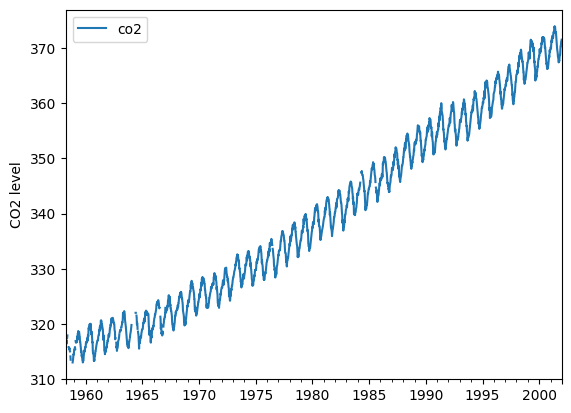

In [5]:
import matplotlib.pyplot as plt
ax = data.plot()
ax.set_ylabel('CO2 level')
plt.show()

This data shows a very obvious sign of an upward trend, which is fairly constant. And
there is also a very clear seasonality pattern in this data (up and down).
Then, we should look at its autocorrelation and partial autocorrelation functions. However, both autocorrelation (ACF) and partial autocorrelation (PACF) plots are relevant only when applied to stationary data.
For this reason, in the next section we will plot ACF and PACF on the differenced data


#### 3 - ACF and PACF plots

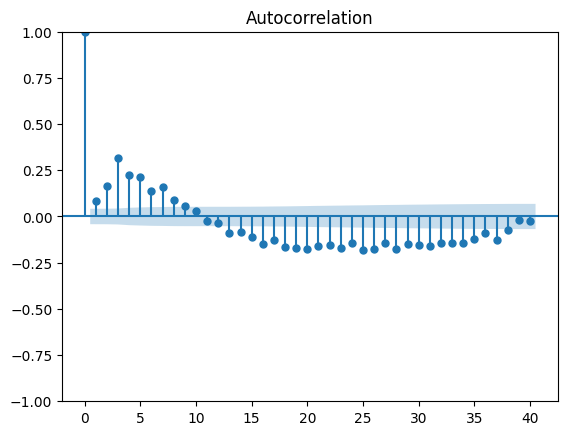

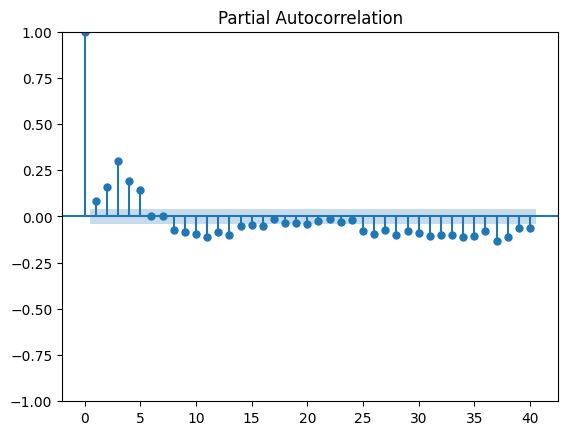

In [6]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(data.diff().dropna(), lags=40)
plot_pacf(data.diff().dropna(), lags=40)
plt.show()